### *Please help by upvoting this kernel to keep motivate me. *

### Exploratory Data Analysis

Feature Enginering is a crucial part in machine learning.
Before start predicting we need to analyze the trend and select features based on the observations.
For that purpose we will start with Exploratory data analysis.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,5)  #defualt figure size

input_path = "../input/m5-forecasting-accuracy/"

sell_prices = pd.read_csv(input_path+'sell_prices.csv')
calendar = pd.read_csv(input_path+'calendar.csv')
sales = pd.read_csv(input_path+'sales_train_validation.csv')
sample_output = pd.read_csv(input_path+'sample_submission.csv')
#print(sell_prices.head())
#print(calendar.head())
#print(sales.head())
#print(sample_output.head())

Data discription we can find in the data section of the problem statement, 
So, we are not analyzing data again. As per the data discription only event related feilds having missing data.
To start with, we will use item catogery visulizations. That will be an effective representaton of the whole dataset.

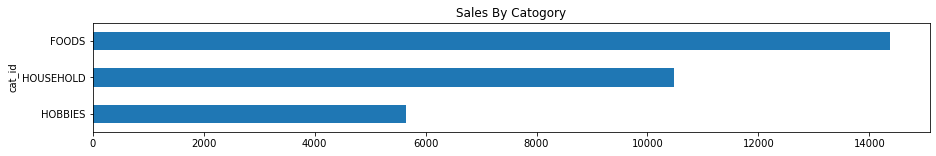

In [14]:
#Sales Catogery
sales.groupby('cat_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By Catogory',width=0.5)
plt.show()

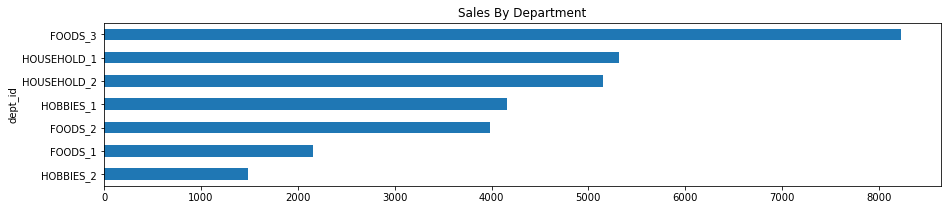

In [15]:
#Sales By Department
sales.groupby('dept_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,3), title='Sales By Department')
plt.show()

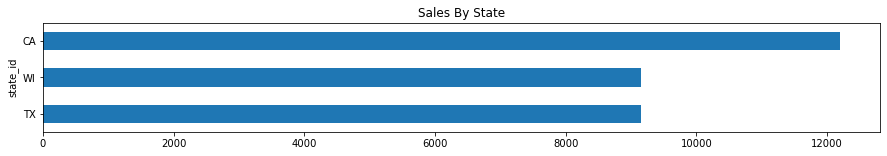

In [17]:
#Sales By State
sales.groupby('state_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By State')
plt.show()

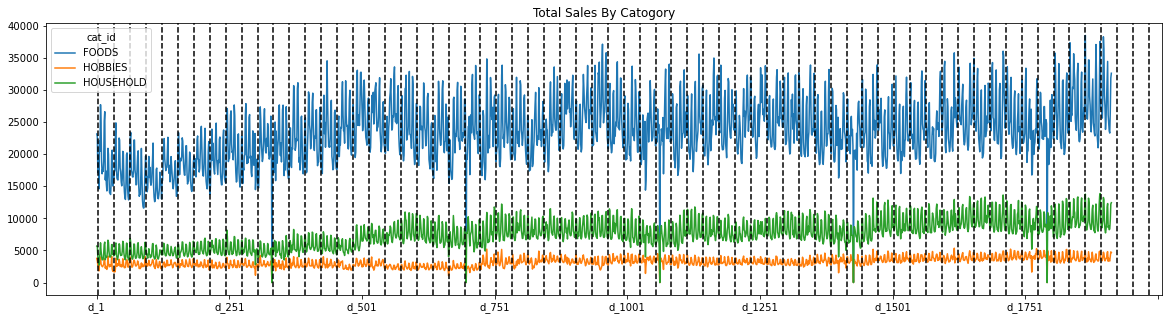

In [18]:
date_columns = [c for c in sales.columns if 'd_' in c] # select date columns
gouped_by_cat_totals = sales.groupby(['cat_id']).sum().T  #get sum and trasnpose
#print(gouped_by_cat_totals.columns)
gouped_by_cat_totals.plot(figsize=(20,5),title="Total Sales By Catogory")
cal_columns = ['d','month']
monthPosition = np.arange(3,2000,30) #Roughly
for xc in monthPosition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.show()

Merge the Calandar data with the sales data

In [20]:
cal_columns = ['date','d','month','year','wday','event_type_1','event_type_2']
calendar_selected = calendar[cal_columns].set_index('d')
total_sales_OverCalendar = pd.concat([calendar_selected,gouped_by_cat_totals],axis=1,sort=False)
print(total_sales_OverCalendar['event_type_1'].unique())
print(total_sales_OverCalendar['event_type_2'].unique())
total_sales_OverCalendar.head()

[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Cultural' 'Religious']


,date,month,year,wday,event_type_1,event_type_2,FOODS,HOBBIES,HOUSEHOLD
d_1,2011-01-29,1,2011,1,NaN,NaN,23178.0,3764.0,5689.0
d_2,2011-01-30,1,2011,2,NaN,NaN,22758.0,3357.0,5634.0
d_3,2011-01-31,1,2011,3,NaN,NaN,17174.0,2682.0,3927.0
d_4,2011-02-01,2,2011,4,NaN,NaN,18878.0,2669.0,3865.0
d_5,2011-02-02,2,2011,5,NaN,NaN,14603.0,1814.0,2729.0


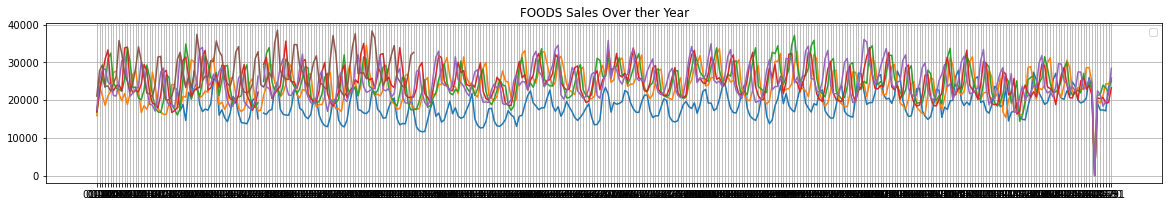

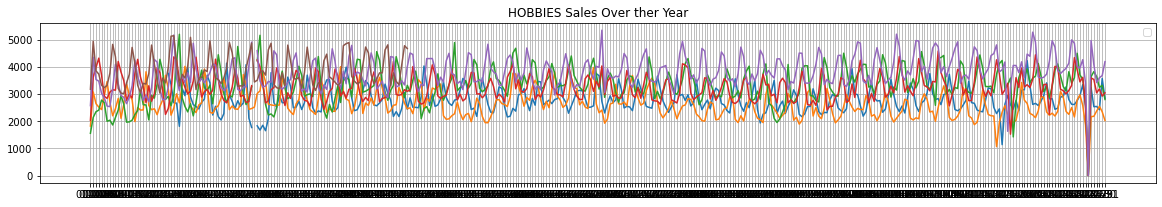

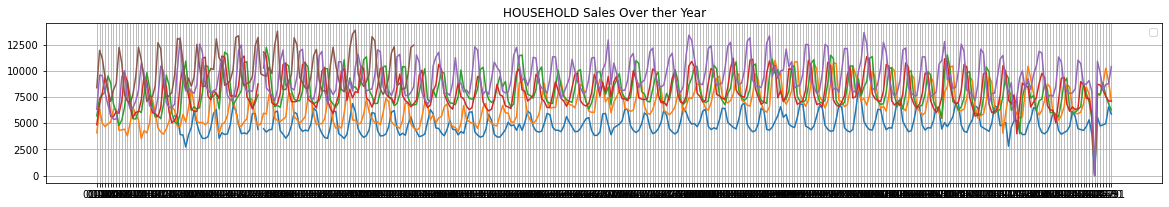

In [21]:
total_sales_OverCalendar['dayOfYear'] = total_sales_OverCalendar['date'].str.slice(5,10)
def plot_pivoted_year(data,name,num):
    plt.figure(figsize=(20,10))
    plt.subplot(3,1,num)
    plt.title(name+" Sales Over ther Year")
    pivoted = data.pivot_table(index='dayOfYear',columns='year',values=name)
    plt.grid()
    plt.plot(pivoted)
    plt.legend()
    plt.show()
    
plot_pivoted_year(total_sales_OverCalendar,'FOODS',1)
plot_pivoted_year(total_sales_OverCalendar,'HOBBIES',2)
plot_pivoted_year(total_sales_OverCalendar,'HOUSEHOLD',3)

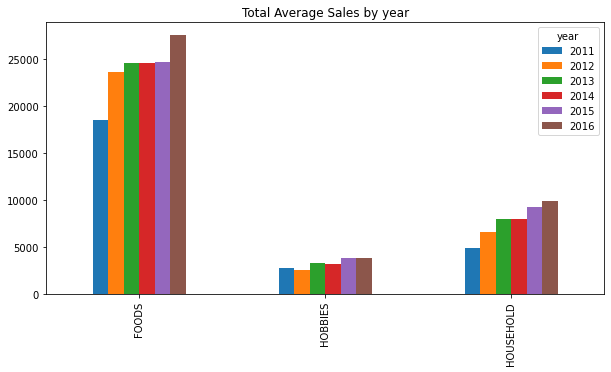

In [26]:
#Yearly growth
gouped_yearly = total_sales_OverCalendar.groupby('year')['FOODS','HOBBIES','HOUSEHOLD'].mean().T
gouped_yearly.plot(kind='bar',title='Total Average Sales by year',figsize=(10,5))
plt.show()

We can clearly see yearly similar trend on each catogory. We can see total sales growth in each year.
2016 we have only half of the years data

### Monthly trend analysis

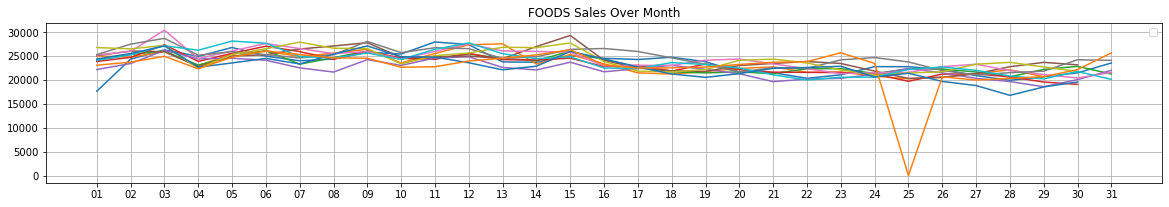

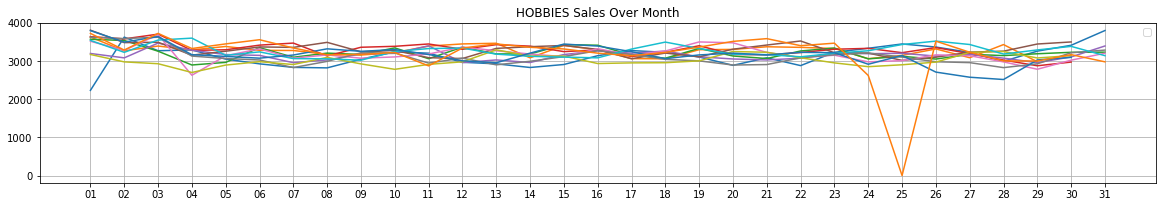

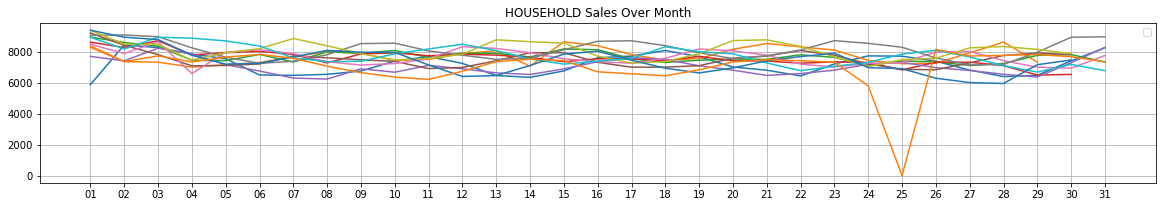

In [27]:
total_sales_OverCalendar['dayOfMonth'] = total_sales_OverCalendar['date'].str.slice(8,10)
def plot_pivoted_month(data,name,num):
    plt.figure(figsize=(20,10))
    plt.subplot(3,1,num)
    plt.title(name+" Sales Over Month")
    pivoted = data.pivot_table(index='dayOfMonth',columns='month',values=name)
    plt.grid()
    plt.plot(pivoted)
    plt.legend()
    plt.show()
    
plot_pivoted_month(total_sales_OverCalendar,'FOODS',1)
plot_pivoted_month(total_sales_OverCalendar,'HOBBIES',2)
plot_pivoted_month(total_sales_OverCalendar,'HOUSEHOLD',3)

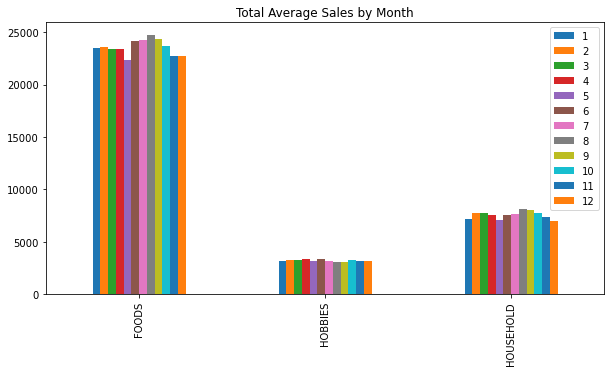

In [29]:
#Monthly growth
gouped_monthly = total_sales_OverCalendar.groupby('month')['FOODS','HOBBIES','HOUSEHOLD'].mean().T
gouped_monthly.plot(kind='bar',title='Total Average Sales by Month',figsize=(10,5))
plt.legend(loc='best')
plt.show()

Events more like to be annual. We will analyze event effect on Sales on following section 

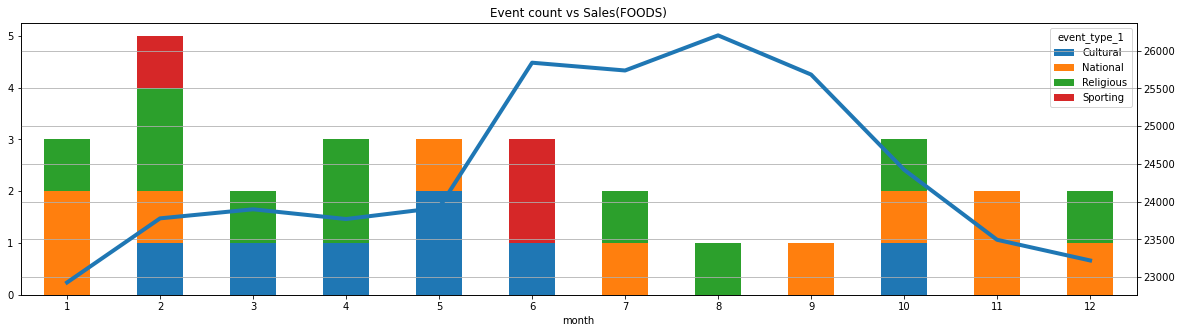

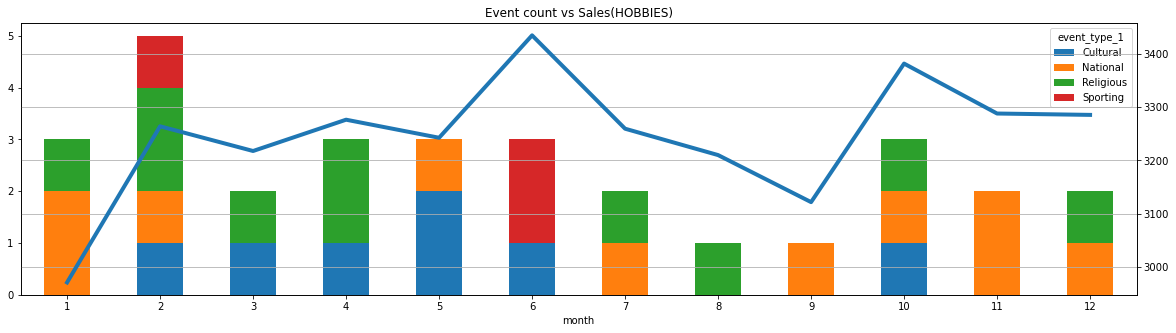

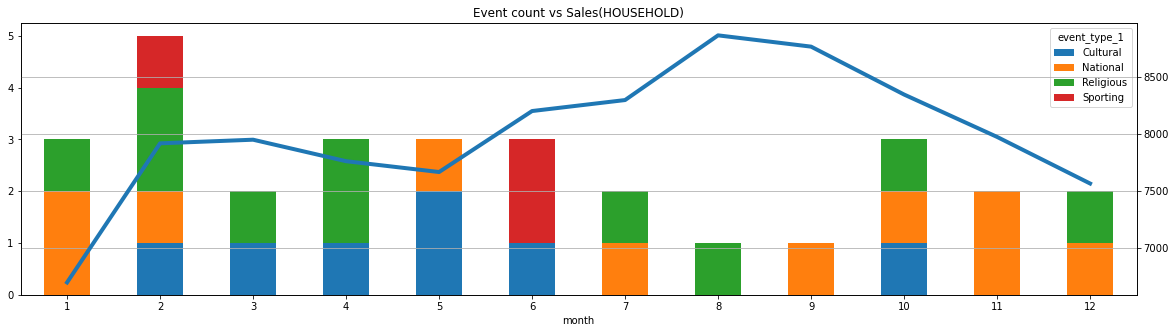

In [31]:
def plotSalesAndEvents(data,eventData,col_name):
    eventData.plot(kind='bar',figsize=(20,5),title='Event count vs Sales('+col_name+')',stacked=True)
    data[col_name].plot(secondary_y=True,figsize=(20,5),linewidth=4)
    plt.grid()
    plt.show()
    
def getEventData(data,eventType):
    eventData = data[data[eventType].notnull()].pivot_table(index='month',columns=eventType,values='wday',aggfunc=len)
    eventData = eventData.fillna(0)
    eventData = eventData.reset_index('month')
    eventData = eventData.set_index('month')
    return eventData
    
#Chose complete year data. 2011 and 2016 we don;t have whole year data.
complete_year_data = total_sales_OverCalendar[ (total_sales_OverCalendar['year']>2011) & (total_sales_OverCalendar['year']<2016)]
gouped_monthly = complete_year_data.groupby('month')['FOODS','HOBBIES','HOUSEHOLD'].mean()
gouped_monthly = gouped_monthly.reset_index('month')
data_2012 = total_sales_OverCalendar[total_sales_OverCalendar['year']==2012]
eventData = getEventData(data_2012,'event_type_1')
plotSalesAndEvents(gouped_monthly,eventData,'FOODS')
plotSalesAndEvents(gouped_monthly,eventData,'HOBBIES')
plotSalesAndEvents(gouped_monthly,eventData,'HOUSEHOLD')

Events can affect sales. Above graphs we can see less number of event seasons people tend to buy more FOOD and household items. People tend to buy HOBIIES catogry when their are more events.

We can clearly see that month 6 having highest sales on HOBIIES catogory where we have highest number of Sporting events for the same month.
Month 8 having highes FOOD and HOUSEHOLD sales where lowest events occur for the same month

### Time Series Data Analysis

To get an idea of the modeling, we will try to pridict result using Time series.
Here, I'm tring to predict total sales for food catogory. 

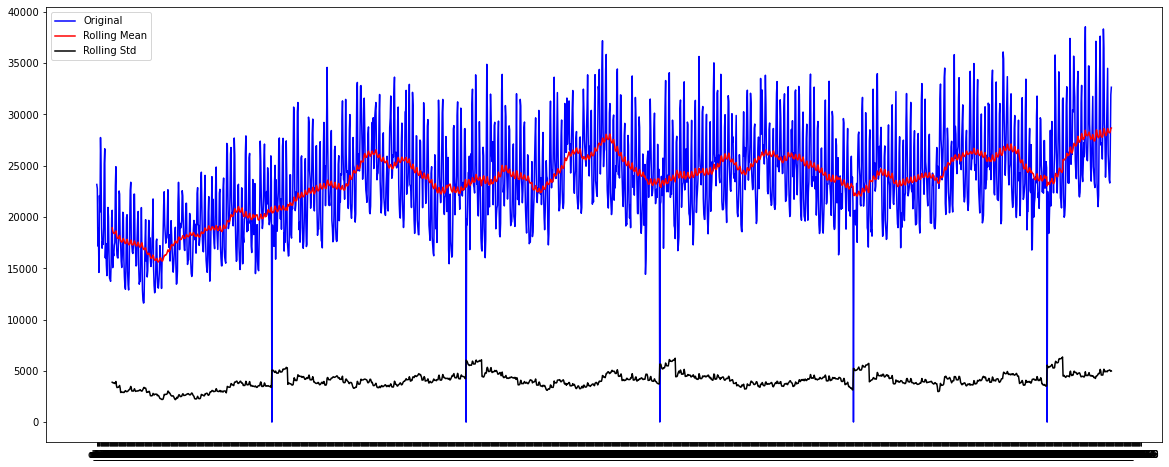

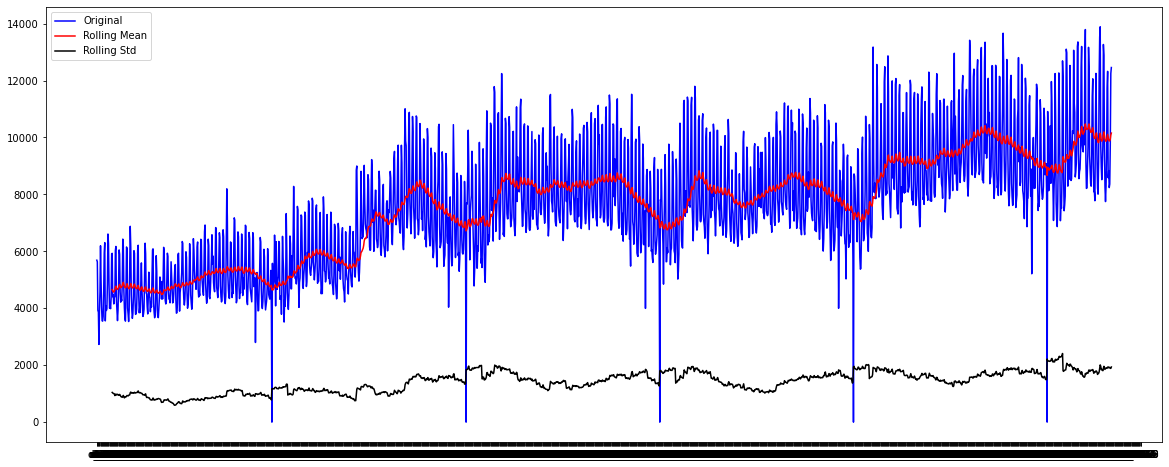

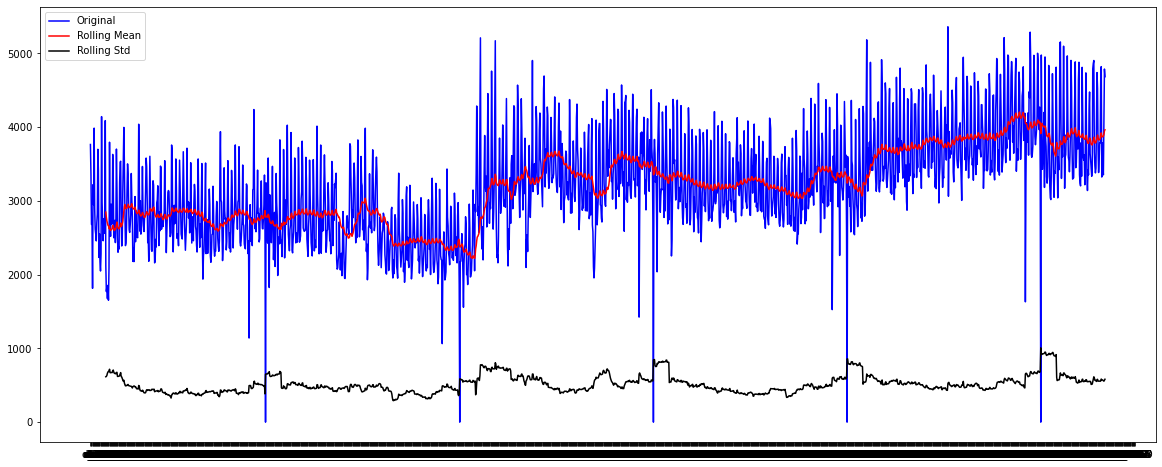

In [32]:
def plot_timeseries_stat(timeseries):
    rollingMean = timeseries.rolling(window=30,center=False).mean()
    rollingStd = timeseries.rolling(window=30,center=False).std()
    plt.figure(figsize=(20,8))
    ori = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rollingMean,color='red',label='Rolling Mean')
    std = plt.plot(rollingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)

plot_timeseries_stat(total_sales_OverCalendar['FOODS'])
plot_timeseries_stat(total_sales_OverCalendar['HOUSEHOLD'])
plot_timeseries_stat(total_sales_OverCalendar['HOBBIES'])

### Modeling start with ARIMA

Test Statistic                 -2.361519
p-value                         0.152893
#Lags Used                     26.000000
No of Observesations Used    1942.000000
Critical Value (1%)            -3.433722
Critical Value (5%)            -2.863029
Critical Value (10%)           -2.567563
dtype: float64


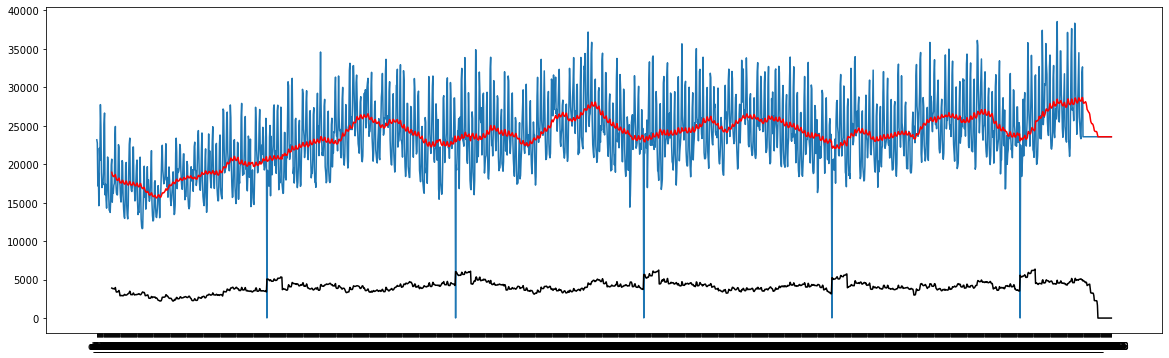

In [33]:
#Making time series stationary
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math

def test_stationarityDF(timeseries): ##Dickey-Fuller Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

food_Series = total_sales_OverCalendar['FOODS']
food_Series.fillna(food_Series.mean(),inplace=True)
test_stationarityDF(food_Series)

movingAverage = food_Series.rolling(window=30).mean()
movingSTD = food_Series.rolling(window=30).std()
plt.figure(figsize=(20,6))
plt.plot(food_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

We can observe that Test Statistic is not below the 1% of the Critical value. So,Series is not stationary.

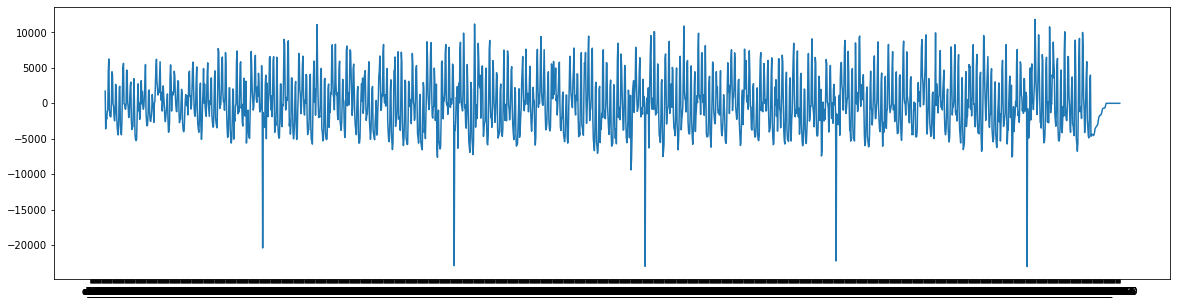

Test Statistic                -8.25633
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1942.00000
Critical Value (1%)           -3.43372
Critical Value (5%)           -2.86303
Critical Value (10%)          -2.56756
dtype: float64


In [34]:
#Make stationarry
foodSeriesDiff = food_Series-movingAverage
plt.figure(figsize=(20,5))
plt.plot(foodSeriesDiff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
foodSeriesDiff.fillna(foodSeriesDiff.mean(),inplace=True)
test_stationarityDF(foodSeriesDiff)

We can observe that Test Statistic is way less than 1% of critical value. So, we can conculde that the above Series is 99% stationary.

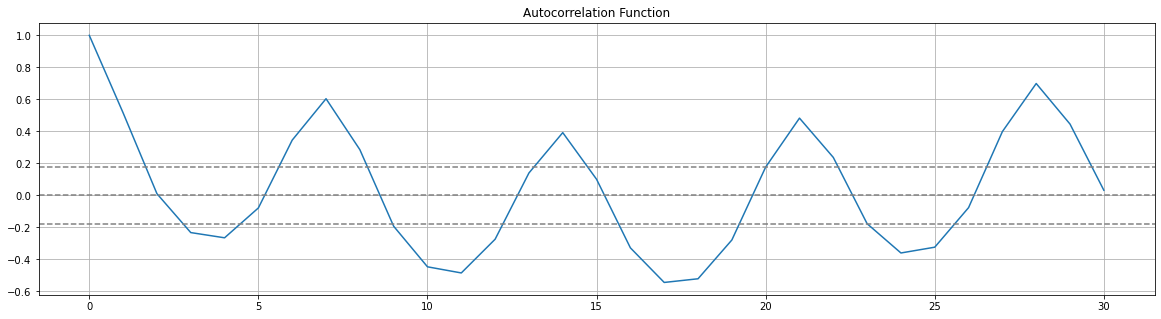

In [35]:
plt.plot(np.arange(0,31,1),acf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.grid()
plt.show()

Correlation function cross upper confident value between 1 and 2. Hence chose 2 as p for ARIMA

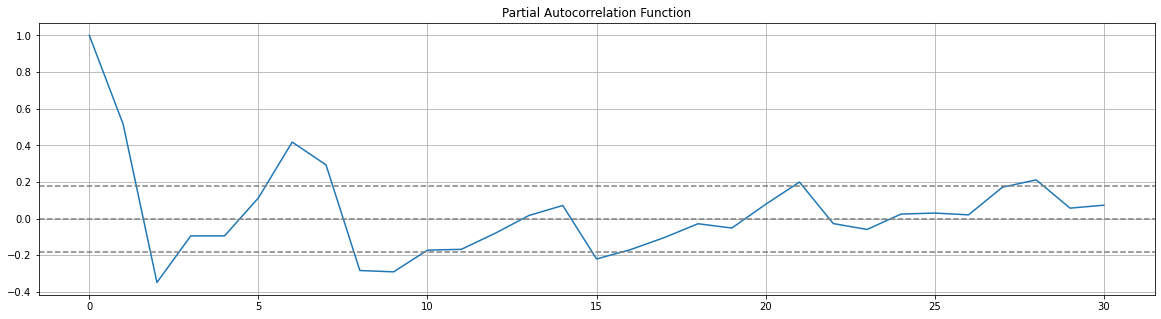

In [37]:
plt.plot(np.arange(0,31,1),pacf(foodSeriesDiff,nlags=30))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(foodSeriesDiff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.grid()
plt.show()

Partial Autocorrelation function drop to 0 when value is between 1 and 2. choose 2 as q value 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


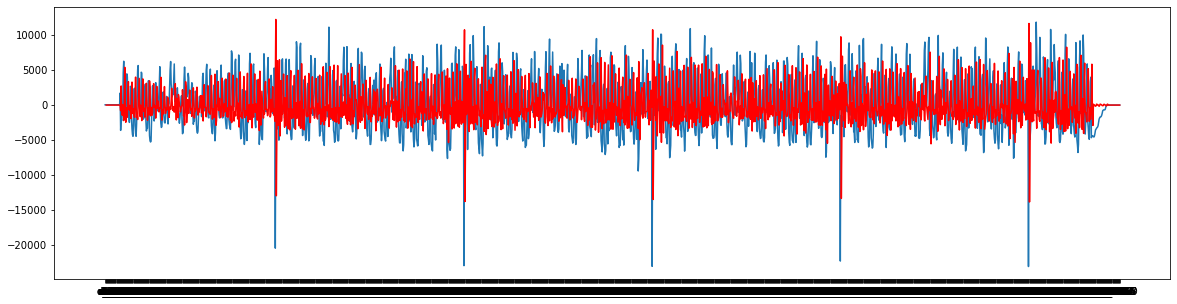

In [38]:
model = ARIMA(foodSeriesDiff,order=(2,2,0))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,5))
plt.plot(foodSeriesDiff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.show()

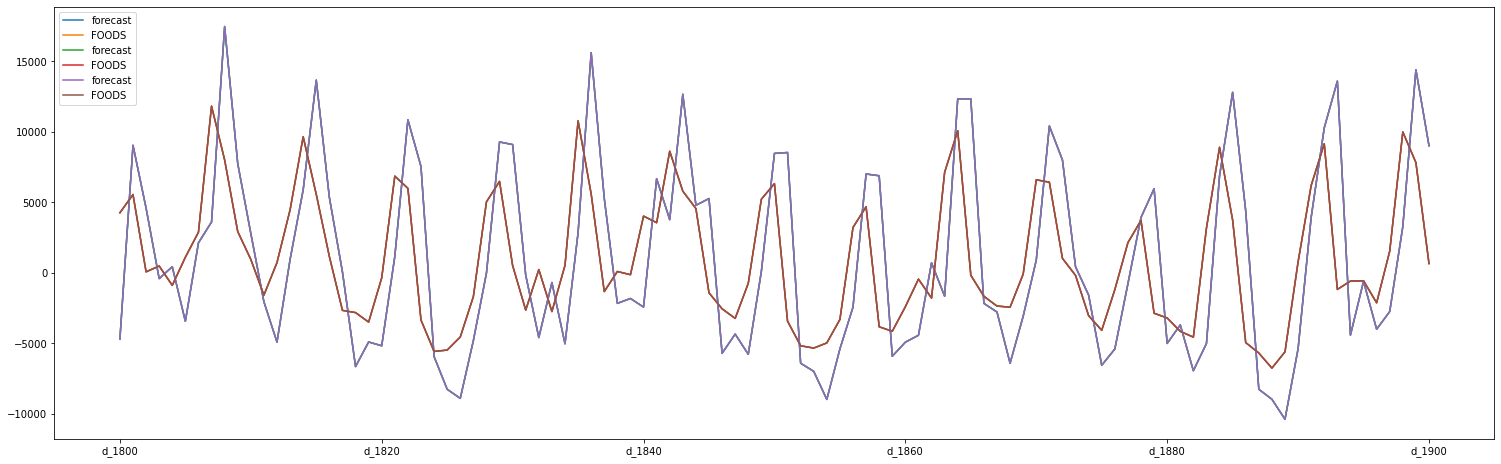

In [45]:
results_ARIMA.plot_predict('d_1800','d_1900',dynamic=False,ax=ax)

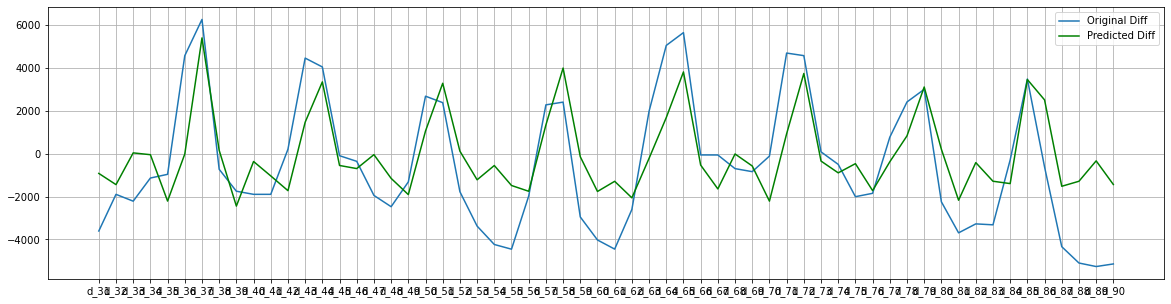

In [46]:
#Plot a portion of data to clear visulization
plt.figure(figsize=(20,5))
ori = plt.plot(foodSeriesDiff.iloc[30:90],label='Original Diff')
#plt.plot(results_ARIMA.fittedvalues.iloc[0:60],color='red')
#plt.plot(results_ARIMA.fittedvalues.iloc[0:60].cumsum(),color='black')
##ARIMA order is 2. show results lags 2 values
#shfited['predicShfited2'] = pd.Series(results_ARIMA.fittedvalues,copy=True)
shfited = pd.DataFrame({'predicShfited2':pd.Series(results_ARIMA.fittedvalues,copy=True),'day':foodSeriesDiff.index[0:1967]})
shfited = shfited.set_index('day')
pre = plt.plot(shfited['predicShfited2'].iloc[30:90],color='green',label='Predicted Diff')
#pre = plt.plot(results_ARIMA.fittedvalues.iloc[0:60],color='green',label='Predicted Diff')
plt.legend(loc='best')
plt.grid()
plt.show()

#### Prediction

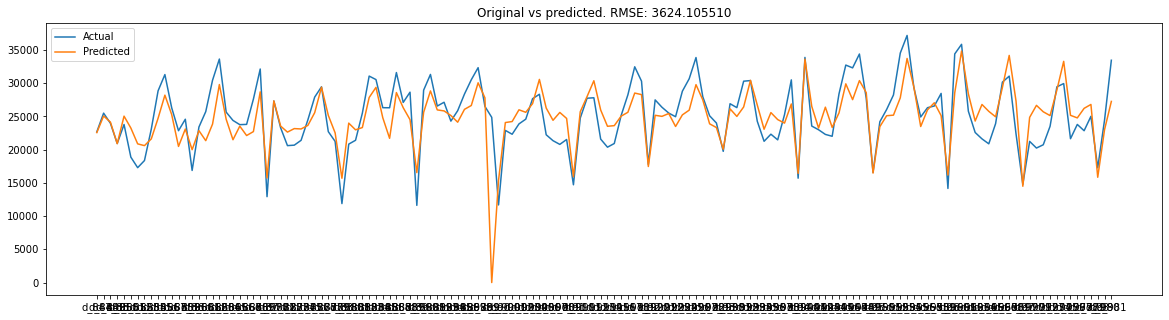

In [47]:
predictions_ARIMA_final = pd.Series(food_Series.at['d_2'],index=food_Series.index)
shfited.loc['d_1'] = 0
shfited.loc['d_2'] = 0
movingAverage.fillna(0)
predictVsActual = pd.DataFrame({'actual':food_Series,'diffMean':foodSeriesDiff,
                                'predictDiffOri':shfited['predicShfited2'],
                                'predictDiff':shfited['predicShfited2'],
                                'base':movingAverage})
predictVsActual['predict'] = predictVsActual.loc[:,['predictDiff','base']].sum(axis=1)
predictVsActual['error'] = predictVsActual['actual'] - predictVsActual['predict']
plt.figure(figsize=(20,5))
plt.plot(predictVsActual['actual'].iloc[1800:1950],label='Actual')
plt.plot(predictVsActual['predict'].iloc[1800:1950],label='Predicted')
#plt.plot(predictVsActual[['actual','predict']])
plt.legend(loc='best')
plt.title('Original vs predicted. RMSE: %4f'%np.sqrt(sum(predictVsActual['error']**2)/len(predictVsActual)))
plt.show()

ARIMA model is based on time series values. But we have more features than the time shift effect.
As a example, events, day of week, month can be considered as few more additional features.

### Feature Selection for Complex Models


Will update this kernel on below section on upcomming days.

1) Feature Selection

2) Various models

3) Evaluate Results